# Candle Dataset Cleaning

After running the first training job on the full dataset, we can see that despite the training loss decreasing, the validation loss is remaining fairly constant. As a potential remedy, we are going to try removing all of the rows from a closed market from the dataset. This will have a few advantages:
1. It will drasitcally reduce the size of the data by approximately 55 - 60%, by keeping only the examples that are relevant to the task we need to perform. 
2. It will ensure that the loss metrics are mearusing the models performnace on market data where trading is occuring. Currently, the loss function is likely dilluted, as so much of the data is just a flat time-series, that the model is likely performing perfectly on these examples, causing the loss metric to be diluted, and likely not allowing a high enough gradient to be built up for the backward pass.

## Plan for Cleaning Data 

1. Remove any rows where the market is closed. We will never be using this in the actual model.
2. This should give us a a couple hundred time-series per ticker. We want to create a time-series ID for each continuous time series in the dataset. This will be used as a column ID.
3. Then iterate over each ticker. For each ticker:
 - Use our date indicices, to create a train, validation, and test set for that ticker. Be sure that the date the sets do not slice any time-series (e.g. each of the 3 sets should have a unique set of time-series IDs)
 - Append eacah of the three sets to a master train, validation, and test set respectively. 
 - These steps will replace the current `select_by_index` usage
4. Train the `TimeSeriesPreprocessor` on the train set
5. Create the train, validation, and test datasets, using the trained preprocessor



In [1]:
# Standard
import os
import random

# Third Party
from transformers import (
    EarlyStoppingCallback,
    PatchTSMixerConfig,
    PatchTSMixerForPrediction,
    Trainer,
    TrainingArguments,
)
import numpy as np
import pandas as pd
import torch
from sklearn.model_selection import train_test_split

# First Party
from tsfm_public.toolkit.dataset import ForecastDFDataset
from tsfm_public.toolkit.time_series_preprocessor import TimeSeriesPreprocessor


In [2]:
# Set seed for reproducibility
SEED = 42
torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)

## Dataset Preprocessing

We want to meticulously craft our examples for each trading day. Our primary focus here is to ensure that the model only is ever asked to forecast into live market data. We need it to understand this type of forecasting, and not be thrown off at all by examples from extended hours trading.

There are a few general steps we must take:
1. Ensure that all the data from the closed market is removed from the dataset, as this data will never be used in context or in forecasting.
2. Ensure that the timestamps are localized to America/New_York, so that we can get accurate date_strings to use for identifying each trading day.

In [5]:
# Load the Dataset from the CSV file
DATA_DIR = "/home/ubuntu/verb-workspace/data" # set this accordingly to the location of the data
DATASET = "10s-candles-2023-RAW.csv"

DATASET_PATH = os.path.join(DATA_DIR, DATASET)
timestamp_col = 't'

data = pd.read_csv(
    DATASET_PATH,
    parse_dates=[timestamp_col]
)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31160015 entries, 0 to 31160014
Data columns (total 10 columns):
 #   Column                             Dtype              
---  ------                             -----              
 0   t                                  datetime64[ns, UTC]
 1   targ_o                             float64            
 2   targ_h                             float64            
 3   targ_l                             float64            
 4   targ_c                             float64            
 5   targ_v                             float64            
 6   ticker                             object             
 7   market_state_MarketState.CLOSED    int64              
 8   market_state_MarketState.EXTENDED  int64              
 9   market_state_MarketState.OPEN      int64              
dtypes: datetime64[ns, UTC](1), float64(5), int64(3), object(1)
memory usage: 2.3+ GB


In [7]:
data

,t,targ_o,targ_h,targ_l,targ_c,targ_v,ticker,market_state_MarketState.CLOSED,market_state_MarketState.EXTENDED,market_state_MarketState.OPEN
0,2023-01-03 09:00:00+00:00,130.28,130.95,130.28,130.95,4233.0,AAPL,0,1,0
1,2023-01-03 09:00:10+00:00,130.98,131.00,130.93,130.93,744.0,AAPL,0,1,0
2,2023-01-03 09:00:20+00:00,130.98,131.00,130.93,130.93,0.0,AAPL,0,1,0
3,2023-01-03 09:00:30+00:00,130.98,131.00,130.93,130.93,0.0,AAPL,0,1,0
4,2023-01-03 09:00:40+00:00,130.98,130.98,130.98,130.98,223.0,AAPL,0,1,0
...,...,...,...,...,...,...,...,...,...,...
31160010,2023-12-29 21:38:30+00:00,260.35,260.35,260.35,260.35,0.0,V,0,1,0
31160011,2023-12-29 21:38:40+00:00,260.35,260.35,260.35,260.35,0.0,V,0,1,0
31160012,2023-12-29 21:38:50+00:00,260.35,260.35,260.35,260.35,0.0,V,0,1,0
31160013,2023-12-29 21:39:00+00:00,260.35,260.35,260.35,260.35,0.0,V,0,1,0


Great, it seems like we have the full dataset loaded into memory. Let's start by removing all the rows where the market is closed.

In [12]:
# Now, let's trim down the dataset, by removing all of the Market Closed columns, this will create several individual time series for each ticker. 
# We can then add a date_string column, to use a second ID column for each time-series

# Remove all rows where the market is closed and reset the index
data = data[data['market_state_MarketState.CLOSED'] != 1].reset_index(drop=True)

original_data = data
data

,t,targ_o,targ_h,targ_l,targ_c,targ_v,ticker,market_state_MarketState.CLOSED,market_state_MarketState.EXTENDED,market_state_MarketState.OPEN
0,2023-01-03 09:00:00+00:00,130.28,130.95,130.28,130.95,4233.0,AAPL,0,1,0
1,2023-01-03 09:00:10+00:00,130.98,131.00,130.93,130.93,744.0,AAPL,0,1,0
2,2023-01-03 09:00:20+00:00,130.98,131.00,130.93,130.93,0.0,AAPL,0,1,0
3,2023-01-03 09:00:30+00:00,130.98,131.00,130.93,130.93,0.0,AAPL,0,1,0
4,2023-01-03 09:00:40+00:00,130.98,130.98,130.98,130.98,223.0,AAPL,0,1,0
...,...,...,...,...,...,...,...,...,...,...
14488410,2023-12-29 21:38:30+00:00,260.35,260.35,260.35,260.35,0.0,V,0,1,0
14488411,2023-12-29 21:38:40+00:00,260.35,260.35,260.35,260.35,0.0,V,0,1,0
14488412,2023-12-29 21:38:50+00:00,260.35,260.35,260.35,260.35,0.0,V,0,1,0
14488413,2023-12-29 21:39:00+00:00,260.35,260.35,260.35,260.35,0.0,V,0,1,0


As we can see, even after adding the additional column, we have reduced the size of the dataset again by almost 50%. We can now remove all of the `market_state` columns, to ensure that we are ready for the full processing steps.

_Note: We have saved the above frame to the `original_data` variable, to allow us to restart if needed, without reloading the CSV into memory._

Now, we want to localize the timestamps, to all be set to America/New_York

In [15]:
data['t'] = data['t'].dt.tz_convert('America/New_York')

data

,t,targ_o,targ_h,targ_l,targ_c,targ_v,ticker,market_state_MarketState.CLOSED,market_state_MarketState.EXTENDED,market_state_MarketState.OPEN
0,2023-01-03 04:00:00-05:00,130.28,130.95,130.28,130.95,4233.0,AAPL,0,1,0
1,2023-01-03 04:00:10-05:00,130.98,131.00,130.93,130.93,744.0,AAPL,0,1,0
2,2023-01-03 04:00:20-05:00,130.98,131.00,130.93,130.93,0.0,AAPL,0,1,0
3,2023-01-03 04:00:30-05:00,130.98,131.00,130.93,130.93,0.0,AAPL,0,1,0
4,2023-01-03 04:00:40-05:00,130.98,130.98,130.98,130.98,223.0,AAPL,0,1,0
...,...,...,...,...,...,...,...,...,...,...
14488410,2023-12-29 16:38:30-05:00,260.35,260.35,260.35,260.35,0.0,V,0,1,0
14488411,2023-12-29 16:38:40-05:00,260.35,260.35,260.35,260.35,0.0,V,0,1,0
14488412,2023-12-29 16:38:50-05:00,260.35,260.35,260.35,260.35,0.0,V,0,1,0
14488413,2023-12-29 16:39:00-05:00,260.35,260.35,260.35,260.35,0.0,V,0,1,0


Now with the time values fixed, we want to remove our Market Closed column, and rename our columns for extend hours and live market hours.

In [17]:
# Remove the unused cols
try:
    data.drop(columns=["market_state_MarketState.CLOSED"], inplace=True)
except KeyError:
    pass

data = data.rename(columns= {
    "market_state_MarketState.EXTENDED": "market_extended",
    "market_state_MarketState.OPEN": "market_open"
})

data

,t,targ_o,targ_h,targ_l,targ_c,targ_v,ticker,market_extended,market_open
0,2023-01-03 04:00:00-05:00,130.28,130.95,130.28,130.95,4233.0,AAPL,1,0
1,2023-01-03 04:00:10-05:00,130.98,131.00,130.93,130.93,744.0,AAPL,1,0
2,2023-01-03 04:00:20-05:00,130.98,131.00,130.93,130.93,0.0,AAPL,1,0
3,2023-01-03 04:00:30-05:00,130.98,131.00,130.93,130.93,0.0,AAPL,1,0
4,2023-01-03 04:00:40-05:00,130.98,130.98,130.98,130.98,223.0,AAPL,1,0
...,...,...,...,...,...,...,...,...,...
14488410,2023-12-29 16:38:30-05:00,260.35,260.35,260.35,260.35,0.0,V,1,0
14488411,2023-12-29 16:38:40-05:00,260.35,260.35,260.35,260.35,0.0,V,1,0
14488412,2023-12-29 16:38:50-05:00,260.35,260.35,260.35,260.35,0.0,V,1,0
14488413,2023-12-29 16:39:00-05:00,260.35,260.35,260.35,260.35,0.0,V,1,0


We should also check to see if we have any NA values still sticking around, and remove all days that have NA values. This will ensure that all of the days in our dataset or complete.

In [24]:
# Assuming your DataFrame is named 'data'
data['date_string'] = data['t'].apply(lambda x: x.strftime('%Y-%m-%d'))

data

,t,targ_o,targ_h,targ_l,targ_c,targ_v,ticker,market_extended,market_open,date_string
0,2023-01-03 04:00:00-05:00,130.28,130.95,130.28,130.95,4233.0,AAPL,1,0,2023-01-03
1,2023-01-03 04:00:10-05:00,130.98,131.00,130.93,130.93,744.0,AAPL,1,0,2023-01-03
2,2023-01-03 04:00:20-05:00,130.98,131.00,130.93,130.93,0.0,AAPL,1,0,2023-01-03
3,2023-01-03 04:00:30-05:00,130.98,131.00,130.93,130.93,0.0,AAPL,1,0,2023-01-03
4,2023-01-03 04:00:40-05:00,130.98,130.98,130.98,130.98,223.0,AAPL,1,0,2023-01-03
...,...,...,...,...,...,...,...,...,...,...
14488410,2023-12-29 16:38:30-05:00,260.35,260.35,260.35,260.35,0.0,V,1,0,2023-12-29
14488411,2023-12-29 16:38:40-05:00,260.35,260.35,260.35,260.35,0.0,V,1,0,2023-12-29
14488412,2023-12-29 16:38:50-05:00,260.35,260.35,260.35,260.35,0.0,V,1,0,2023-12-29
14488413,2023-12-29 16:39:00-05:00,260.35,260.35,260.35,260.35,0.0,V,1,0,2023-12-29


In [30]:
# Get all the groups of the ticker-date pairs
ticker_date_groups = data.groupby(['ticker', 'date_string'])

count = 0
for name, group in ticker_date_groups:
    if group.isna().any().any():
        count += 1

print(f"Total Number of NA Days: {count}")
count / len(ticker_date_groups)

Total Number of NA Days: 616


0.24541832669322708

For now, let's just remove all of these days, and keep our 75 percent of valid training data.

In [32]:
# Create a boolean mask for each group indicating the presence of NA values
group_mask = ticker_date_groups.apply(lambda x: x.isna().any().any())

# Get the names of the groups to keep (groups without NA values)
groups_to_keep = group_mask[~group_mask].index

# Filter the DataFrame to keep only the groups without NA values
data_filtered = data[data.set_index(['ticker', 'date_string']).index.isin(groups_to_keep)]

data_filtered

/tmp/ipykernel_939/68796034.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  group_mask = ticker_date_groups.apply(lambda x: x.isna().any().any())


,t,targ_o,targ_h,targ_l,targ_c,targ_v,ticker,market_extended,market_open,date_string
0,2023-01-03 04:00:00-05:00,130.28,130.95,130.28,130.95,4233.0,AAPL,1,0,2023-01-03
1,2023-01-03 04:00:10-05:00,130.98,131.00,130.93,130.93,744.0,AAPL,1,0,2023-01-03
2,2023-01-03 04:00:20-05:00,130.98,131.00,130.93,130.93,0.0,AAPL,1,0,2023-01-03
3,2023-01-03 04:00:30-05:00,130.98,131.00,130.93,130.93,0.0,AAPL,1,0,2023-01-03
4,2023-01-03 04:00:40-05:00,130.98,130.98,130.98,130.98,223.0,AAPL,1,0,2023-01-03
...,...,...,...,...,...,...,...,...,...,...
14330854,2023-11-17 19:59:10-05:00,249.20,249.20,249.20,249.20,0.0,V,1,0,2023-11-17
14330855,2023-11-17 19:59:20-05:00,249.20,249.20,249.20,249.20,0.0,V,1,0,2023-11-17
14330856,2023-11-17 19:59:30-05:00,249.20,249.20,249.20,249.20,0.0,V,1,0,2023-11-17
14330857,2023-11-17 19:59:40-05:00,249.20,249.20,249.20,249.20,0.0,V,1,0,2023-11-17


In [33]:
data_ticker_dates = data_filtered[['ticker', 'date_string']].drop_duplicates()

print(f"Number of unique ticker-date pairs in train set: {len(data_ticker_dates)}")

Number of unique ticker-date pairs in train set: 1894


In [35]:
# Verify all of our NA values are removed

data_filtered.isna().sum()

t                  0
targ_o             0
targ_h             0
targ_l             0
targ_c             0
targ_v             0
ticker             0
market_extended    0
market_open        0
date_string        0
dtype: int64

Now, we should check and make sure that all of the counts for the number of rows in each group is correct. In other words, this will help us make sure that every day has the right amount of training examples.

In [36]:
data_filtered

,t,targ_o,targ_h,targ_l,targ_c,targ_v,ticker,market_extended,market_open,date_string
0,2023-01-03 04:00:00-05:00,130.28,130.95,130.28,130.95,4233.0,AAPL,1,0,2023-01-03
1,2023-01-03 04:00:10-05:00,130.98,131.00,130.93,130.93,744.0,AAPL,1,0,2023-01-03
2,2023-01-03 04:00:20-05:00,130.98,131.00,130.93,130.93,0.0,AAPL,1,0,2023-01-03
3,2023-01-03 04:00:30-05:00,130.98,131.00,130.93,130.93,0.0,AAPL,1,0,2023-01-03
4,2023-01-03 04:00:40-05:00,130.98,130.98,130.98,130.98,223.0,AAPL,1,0,2023-01-03
...,...,...,...,...,...,...,...,...,...,...
14330854,2023-11-17 19:59:10-05:00,249.20,249.20,249.20,249.20,0.0,V,1,0,2023-11-17
14330855,2023-11-17 19:59:20-05:00,249.20,249.20,249.20,249.20,0.0,V,1,0,2023-11-17
14330856,2023-11-17 19:59:30-05:00,249.20,249.20,249.20,249.20,0.0,V,1,0,2023-11-17
14330857,2023-11-17 19:59:40-05:00,249.20,249.20,249.20,249.20,0.0,V,1,0,2023-11-17


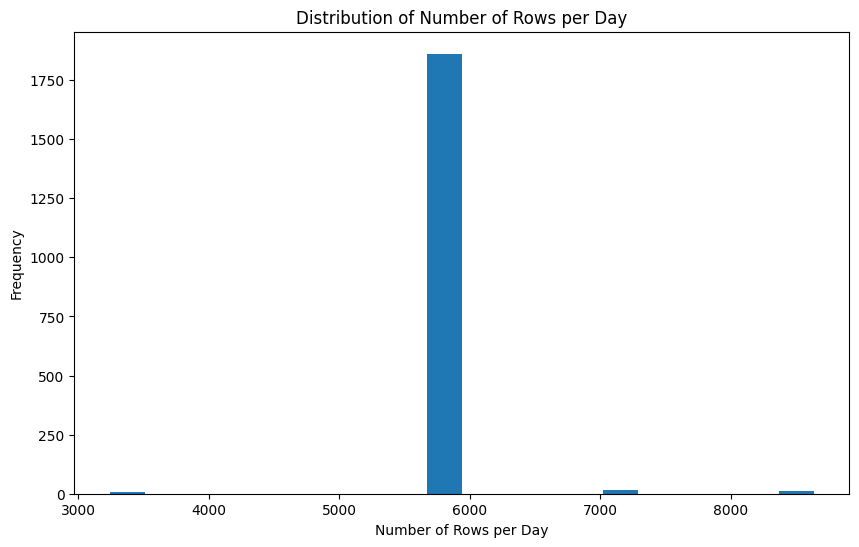

In [39]:
import matplotlib.pyplot as plt

day_counts = data_filtered.groupby(['date_string', 'ticker']).size().reset_index(name='count')

plt.figure(figsize=(10, 6))
plt.hist(day_counts['count'], bins=20)
plt.xlabel('Number of Rows per Day')
plt.ylabel('Frequency')
plt.title('Distribution of Number of Rows per Day')
plt.show()

As we can see, we have some serious outliars. To keep things simple for training, let's remove all days outside of that 5000-6000 range

In [44]:
# Filter day_counts to keep groups with count between 5000 and 6000
day_counts_filtered = day_counts[(day_counts['count'] >= 5000) & (day_counts['count'] <= 6000)]

# Merge data_filtered with day_counts_filtered to keep only the desired groups
data_filtered_uniform = data_filtered.merge(day_counts_filtered[['date_string', 'ticker']], on=['date_string', 'ticker'])

# Ensure the day counts in our dataframe have been properly filtered
data_filtered_uniform.groupby(['date_string', 'ticker']).size().unique()

array([5760, 5746, 5725, 5755, 5758])

In [46]:
data_filtered_uniform

,t,targ_o,targ_h,targ_l,targ_c,targ_v,ticker,market_extended,market_open,date_string
0,2023-01-03 04:00:00-05:00,130.28,130.95,130.28,130.95,4233.0,AAPL,1,0,2023-01-03
1,2023-01-03 04:00:10-05:00,130.98,131.00,130.93,130.93,744.0,AAPL,1,0,2023-01-03
2,2023-01-03 04:00:20-05:00,130.98,131.00,130.93,130.93,0.0,AAPL,1,0,2023-01-03
3,2023-01-03 04:00:30-05:00,130.98,131.00,130.93,130.93,0.0,AAPL,1,0,2023-01-03
4,2023-01-03 04:00:40-05:00,130.98,130.98,130.98,130.98,223.0,AAPL,1,0,2023-01-03
...,...,...,...,...,...,...,...,...,...,...
10719299,2023-11-17 19:59:10-05:00,249.20,249.20,249.20,249.20,0.0,V,1,0,2023-11-17
10719300,2023-11-17 19:59:20-05:00,249.20,249.20,249.20,249.20,0.0,V,1,0,2023-11-17
10719301,2023-11-17 19:59:30-05:00,249.20,249.20,249.20,249.20,0.0,V,1,0,2023-11-17
10719302,2023-11-17 19:59:40-05:00,249.20,249.20,249.20,249.20,0.0,V,1,0,2023-11-17


In [90]:
def augment_group(group):
    group = group.reset_index(drop=True)
    market_open_index = group.loc[group['market_open'] == 1].index[0]
    
    if market_open_index < 1440:
       # Add missing rows at the beginning of the day
        missing_rows = 1440 - market_open_index
        first_row = group.iloc[0]
        new_rows = pd.DataFrame(
            {
                'targ_o': [first_row['targ_o']] * missing_rows,
                'targ_h': [first_row['targ_o']] * missing_rows,
                'targ_l': [first_row['targ_o']] * missing_rows,
                'targ_c': [first_row['targ_o']] * missing_rows,
                'targ_v': [0] * missing_rows,
                'ticker': [first_row['ticker']] * missing_rows,
                'market_extended': [1] * missing_rows,
                'market_open': [0] * missing_rows,
                'date_string': [first_row['date_string']] * missing_rows
            },
            index=pd.RangeIndex(start=0, stop=missing_rows, step=1)
        )
        group = pd.concat([new_rows, group], ignore_index=True)
    elif market_open_index > 1440:
        # Remove excess rows at the beginning of the day
        group = group.iloc[market_open_index - 1440:]
    
    # Trim the day to end at 16:00:00 (market close)
    group.reset_index(inplace=True, drop=True)
    group = group.iloc[:3780]

    assert group.shape == (3780, 10), f"Incorrect shape: {group.shape}"

    market_open_index = group.loc[group['market_open'] == 1].index[0] 
    assert market_open_index == 1440, f"Incorrect open index: {market_open_index}"

    extended_hours_count = group.loc[group['market_extended'] == 1].market_extended.sum()
    assert extended_hours_count == 1440, f"Incorrect extended hours count: {extended_hours_count}"

    live_hours_count = group.loc[group['market_open'] == 1].market_open.sum()
    assert live_hours_count == 2340, f"Incorrect live hours count: {live_hours_count}"
    
    return group

test_date = '2023-01-03'  # Replace with the desired date_string
test_ticker = 'AAPL'  # Replace with the desired ticker

test_group = data_filtered_uniform[(data_filtered_uniform['date_string'] == test_date) & (data_filtered_uniform['ticker'] == test_ticker)]
augmented_test_group = augment_group(test_group)

print(f"Original group shape: {test_group.shape}")
print(f"Augmented group shape: {augmented_test_group.shape}")
print(f"Market open index: {augmented_test_group.loc[augmented_test_group['market_open'] == 1].index[0]}")
print(f"Last index: {augmented_test_group.index[-1]}")
augmented_test_group

Original group shape: (5760, 10)
Augmented group shape: (3780, 10)
Market open index: 1440
Last index: 3779


,t,targ_o,targ_h,targ_l,targ_c,targ_v,ticker,market_extended,market_open,date_string
0,2023-01-03 05:30:00-05:00,130.8000,130.800,130.800,130.80,0.0,AAPL,1,0,2023-01-03
1,2023-01-03 05:30:10-05:00,130.8000,130.800,130.800,130.80,0.0,AAPL,1,0,2023-01-03
2,2023-01-03 05:30:20-05:00,130.8000,130.800,130.800,130.80,0.0,AAPL,1,0,2023-01-03
3,2023-01-03 05:30:30-05:00,130.8000,130.800,130.800,130.80,0.0,AAPL,1,0,2023-01-03
4,2023-01-03 05:30:40-05:00,130.8000,130.800,130.800,130.80,0.0,AAPL,1,0,2023-01-03
...,...,...,...,...,...,...,...,...,...,...
3775,2023-01-03 15:59:10-05:00,125.1519,125.179,125.105,125.12,160869.0,AAPL,0,1,2023-01-03
3776,2023-01-03 15:59:20-05:00,125.1300,125.160,125.110,125.13,132327.0,AAPL,0,1,2023-01-03
3777,2023-01-03 15:59:30-05:00,125.1400,125.150,125.110,125.12,122749.0,AAPL,0,1,2023-01-03
3778,2023-01-03 15:59:40-05:00,125.1300,125.180,125.090,125.16,134692.0,AAPL,0,1,2023-01-03


In [93]:
data_ticker_dates = data_filtered_uniform[['ticker', 'date_string']].drop_duplicates()

In [94]:
from tqdm import tqdm

augmented_groups = []
error_count = 0

for (ticker, date_string), group in tqdm(data_filtered_uniform.groupby(['ticker', 'date_string']), total=len(data_ticker_dates)):
    try:
        augmented_group = augment_group(group)
        augmented_groups.append(augmented_group)
    except AssertionError as err:
        error_count += 1
        print(f"Assertion error for group: {ticker} - {date_string}: {str(err)}")
        continue

print(f"Total groups processed: {len(data_filtered_uniform.groupby(['ticker', 'date_string']))}")
print(f"Groups with assertion errors: {error_count}")

df = pd.concat(augmented_groups, ignore_index=True)
df.reset_index(drop=True, inplace=True)

100%|██████████| 1861/1861 [00:08<00:00, 218.29it/s]


Total groups processed: 1861
Groups with assertion errors: 0


In [95]:
df

,t,targ_o,targ_h,targ_l,targ_c,targ_v,ticker,market_extended,market_open,date_string
0,2023-01-03 05:30:00-05:00,130.800,130.800,130.80,130.800,0.0,AAPL,1,0,2023-01-03
1,2023-01-03 05:30:10-05:00,130.800,130.800,130.80,130.800,0.0,AAPL,1,0,2023-01-03
2,2023-01-03 05:30:20-05:00,130.800,130.800,130.80,130.800,0.0,AAPL,1,0,2023-01-03
3,2023-01-03 05:30:30-05:00,130.800,130.800,130.80,130.800,0.0,AAPL,1,0,2023-01-03
4,2023-01-03 05:30:40-05:00,130.800,130.800,130.80,130.800,0.0,AAPL,1,0,2023-01-03
...,...,...,...,...,...,...,...,...,...,...
7034575,2023-11-17 15:59:10-05:00,249.640,249.645,249.59,249.610,12233.0,V,0,1,2023-11-17
7034576,2023-11-17 15:59:20-05:00,249.605,249.655,249.59,249.635,13620.0,V,0,1,2023-11-17
7034577,2023-11-17 15:59:30-05:00,249.640,249.640,249.59,249.595,9923.0,V,0,1,2023-11-17
7034578,2023-11-17 15:59:40-05:00,249.590,249.630,249.55,249.550,20377.0,V,0,1,2023-11-17


In [107]:
# Get the unique ticker-date pairs from df
ticker_date_pairs = df[['ticker', 'date_string']].drop_duplicates()

# Shuffle the ticker-date pairs randomly
shuffled_pairs = ticker_date_pairs.sample(frac=1, random_state=42)

# Calculate the number of pairs for each split
total_pairs = len(shuffled_pairs)
train_size = int(total_pairs * 0.8)
valid_size = int(total_pairs * 0.1)
test_size = total_pairs - train_size - valid_size

assert int(total_pairs * 0.8) == train_size
assert int(total_pairs * 0.1) == valid_size

In [108]:
# Split the shuffled pairs into train, validation, and test sets
train_pairs = shuffled_pairs[:train_size]
valid_pairs = shuffled_pairs[train_size:train_size+valid_size]
test_pairs = shuffled_pairs[train_size+valid_size:]

In [112]:
# Create separate DataFrames for each split
train_df = df[df.set_index(['ticker', 'date_string']).index.isin(train_pairs.set_index(['ticker', 'date_string']).index)]
valid_df = df[df.set_index(['ticker', 'date_string']).index.isin(valid_pairs.set_index(['ticker', 'date_string']).index)]
test_df = df[df.set_index(['ticker', 'date_string']).index.isin(test_pairs.set_index(['ticker', 'date_string']).index)]

assert len(train_df) / 3780 == train_size
assert len(valid_df) / 3780 == valid_size
assert len(test_df) / 3780 == test_size

In [113]:
# Reset the index of each DataFrame
train_df.reset_index(drop=True, inplace=True)
valid_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

# Print the shapes of the resulting DataFrames
print("Train DataFrame shape:", train_df.shape)
print("Validation DataFrame shape:", valid_df.shape)
print("Test DataFrame shape:", test_df.shape)

Train DataFrame shape: (5624640, 10)
Validation DataFrame shape: (703080, 10)
Test DataFrame shape: (706860, 10)


In [116]:
assert train_df.isna().sum().sum() + test_df.isna().sum().sum() + valid_df.isna().sum().sum() == 0

In [117]:
# Save train_df to CSV
train_df.to_csv(f"{DATA_DIR}/10s-candles-train.csv", index=False, date_format='%Y-%m-%d %H:%M:%S%z')

# Save valid_df to CSV
valid_df.to_csv(f"{DATA_DIR}/10s-candles-valid.csv", index=False, date_format='%Y-%m-%d %H:%M:%S%z')

# Save test_df to CSV
test_df.to_csv(f"{DATA_DIR}/10s-candles-test.csv", index=False, date_format='%Y-%m-%d %H:%M:%S%z')